In [32]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import copy
import os
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [17]:
DATA_PATH = "/home/alex/Downloads/archive(1)/data/fma_genre_spectrograms"

In [8]:
# HINT: Use this class mapping to merge similar classes and ignore classes that do not work very well
CLASS_MAPPING = {
    "Rock": "Rock",
    "Psych-Rock": "Rock",
    "Indie-Rock": None,
    "Post-Rock": "Rock",
    "Psych-Folk": "Folk",
    "Folk": "Folk",
    "Metal": "Metal",
    "Punk": "Metal",
    "Post-Punk": None,
    "Trip-Hop": "Trip-Hop",
    "Pop": "Pop",
    "Electronic": "Electronic",
    "Hip-Hop": "Hip-Hop",
    "Classical": "Classical",
    "Blues": "Blues",
    "Chiptune": "Electronic",
    "Jazz": "Jazz",
    "Soundtrack": None,
    "International": None,
    "Old-Time": None,
}


def torch_train_val_split(
    dataset, batch_train, batch_eval, val_size=0.2, shuffle=True, seed=420
):
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_split = int(np.floor(val_size * dataset_size))
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
    train_indices = indices[val_split:]
    val_indices = indices[:val_split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset, batch_size=batch_train, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_eval, sampler=val_sampler)
    return train_loader, val_loader


def read_spectrogram(spectrogram_file, feat_type):
    spectrogram = np.load(spectrogram_file)
    # spectrograms contains a fused mel spectrogram and chromagram    
    if feat_type=='mel':
        return spectrogram[:128, :].T
    elif feat_type=='chroma':
        return spectrogram[128:, :].T

    return spectrogram.T


class LabelTransformer(LabelEncoder):
    def inverse(self, y):
        try:
            return super(LabelTransformer, self).inverse_transform(y)
        except:
            return super(LabelTransformer, self).inverse_transform([y])

    def transform(self, y):
        try:
            return super(LabelTransformer, self).transform(y)
        except:
            return super(LabelTransformer, self).transform([y])


class PaddingTransform(object):
    def __init__(self, max_length, padding_value=0):
        self.max_length = max_length
        self.padding_value = padding_value

    def __call__(self, s):
        if len(s) == self.max_length:
            return s

        if len(s) > self.max_length:
            return s[: self.max_length]

        if len(s) < self.max_length:
            s1 = copy.deepcopy(s)
            pad = np.zeros((self.max_length - s.shape[0], s.shape[1]), dtype=np.float32)
            s1 = np.vstack((s1, pad))
            return s1


class SpectrogramDataset(Dataset):
    def __init__(
        self, path, class_mapping=None, train=True, feat_type='mel', max_length=-1, regression=None
    ):
        t = "train" if train else "test"
        p = os.path.join(path, t)
        self.regression = regression

        self.full_path = p
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        self.files, labels = self.get_files_labels(self.index, class_mapping)
        self.feats = [read_spectrogram(os.path.join(p, f), feat_type) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        self.label_transformer = LabelTransformer()
        if isinstance(labels, (list, tuple)):
            if not regression:
                self.labels = np.array(
                    self.label_transformer.fit_transform(labels)
                ).astype("int64")
            else:
                self.labels = np.array(labels).astype("float64")

    def get_files_labels(self, txt, class_mapping):
        with open(txt, "r") as fd:
            lines = [l.rstrip().split("\t") for l in fd.readlines()[1:]]
        files, labels = [], []
        for l in lines:
            if self.regression:
                l = l[0].split(",")
                files.append(l[0] + ".fused.full.npy")
                labels.append(l[self.regression])
                continue
            label = l[1]
            if class_mapping:
                label = class_mapping[l[1]]
            if not label:
                continue
            fname = l[0]
            if fname.endswith(".gz"):
                fname = ".".join(fname.split(".")[:-1])
            
            # necessary fixes for the custom dataset used in the lab
            if 'fma_genre_spectrograms_beat' in self.full_path.split('/'):
                fname = fname.replace('beatsync.fused', 'fused.full')            
            if 'test' in self.full_path.split('/'):
                fname = fname.replace('full.fused', 'fused.full')
            
            files.append(fname)
            labels.append(label)
        return files, labels

    def __getitem__(self, item):
        length = min(self.lengths[item], self.max_length)
        return self.zero_pad_and_stack(self.feats[item]), self.labels[item], length

    def __len__(self):
        return len(self.labels)


In [12]:
full_dataset = SpectrogramDataset(DATA_PATH, class_mapping=None, train=True)

merged_dataset = SpectrogramDataset(DATA_PATH, class_mapping=CLASS_MAPPING, train=True)

len(full_dataset), len(merged_dataset)

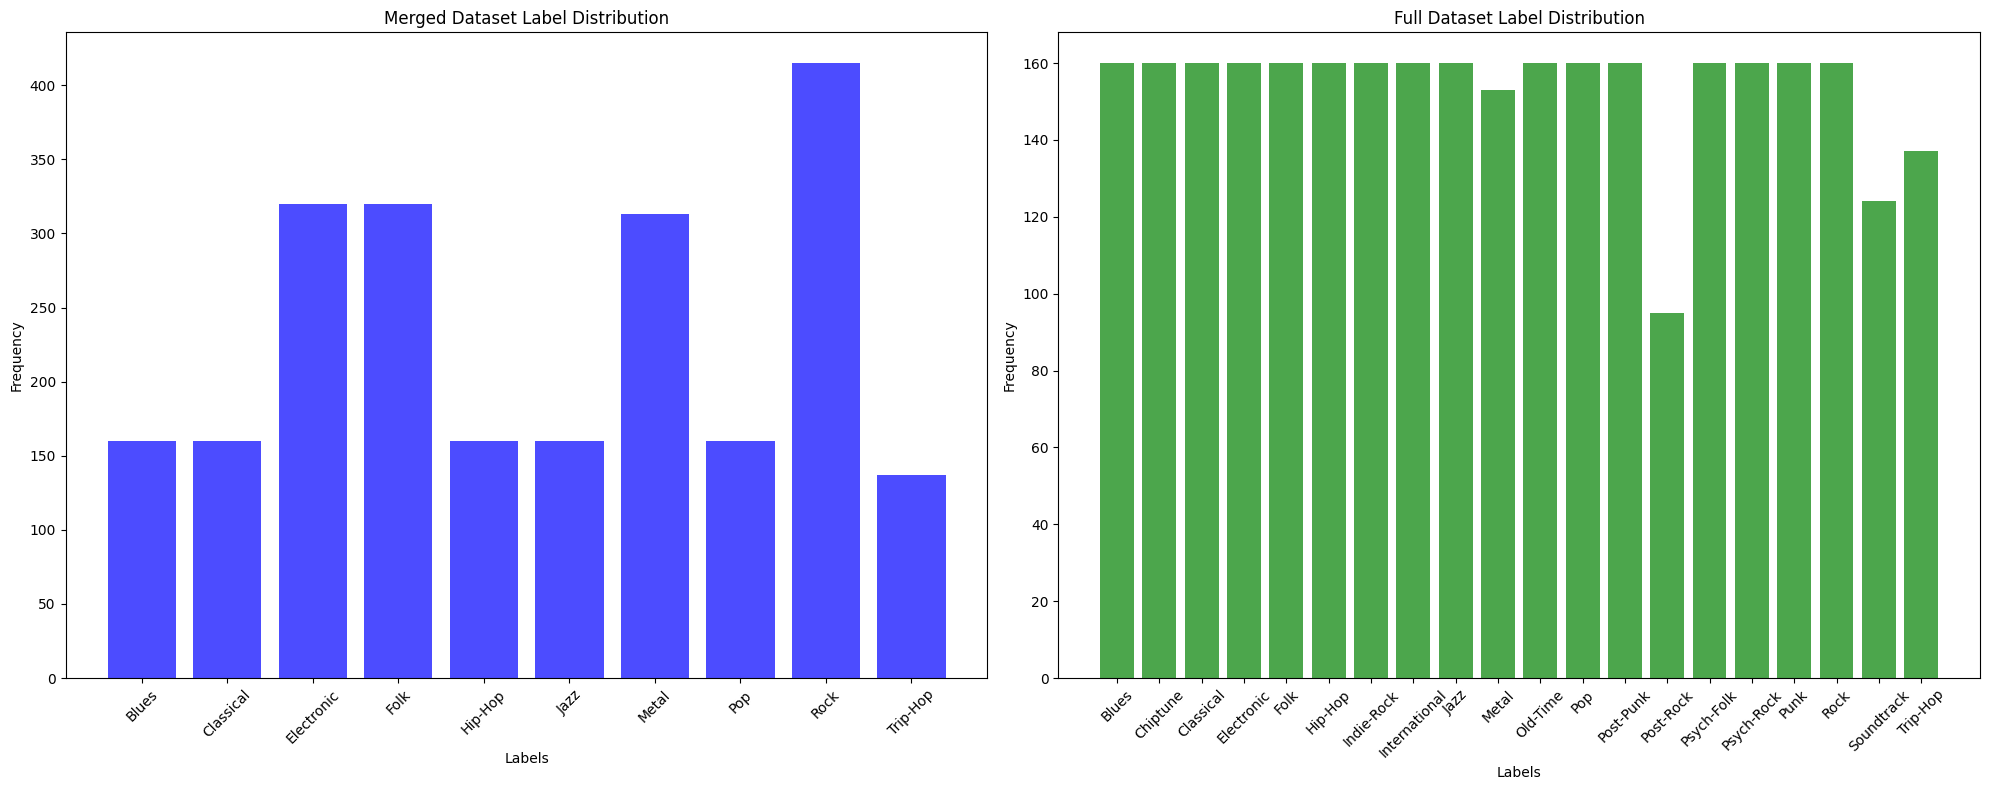

In [31]:
# calculate label frequencies
merged_label_counts = Counter(merged_dataset.labels)
full_label_counts = Counter(full_dataset.labels)

# extract data for  plot
merged_labels, merged_frequencies = zip(*sorted(merged_label_counts.items()))
full_labels, full_frequencies = zip(*sorted(full_label_counts.items()))

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].bar(range(len(merged_labels)), merged_frequencies, color='blue', alpha=0.7)
axes[0].set_title("Merged Dataset Label Distribution")
axes[0].set_xlabel("Labels")
axes[0].set_ylabel("Frequency")
axes[0].set_xticks(range(len(merged_labels)))
axes[0].set_xticklabels(
    merged_dataset.label_transformer.inverse_transform(merged_labels), rotation=45
)

axes[1].bar(range(len(full_labels)), full_frequencies, color='green', alpha=0.7)
axes[1].set_title("Full Dataset Label Distribution")
axes[1].set_xlabel("Labels")
axes[1].set_ylabel("Frequency")
axes[1].set_xticks(range(len(full_labels)))
axes[1].set_xticklabels(
    full_dataset.label_transformer.inverse_transform(full_labels), rotation=45
)

plt.tight_layout()
plt.show()


In [33]:
class PadPackedSequence(nn.Module):
    def __init__(self):
        """Wrap sequence padding in nn.Module
        Args:
            batch_first (bool, optional): Use batch first representation. Defaults to True.
        """
        super(PadPackedSequence, self).__init__()
        self.batch_first = True
        self.max_length = None

    def forward(self, x):
        """Convert packed sequence to padded sequence
        Args:
            x (torch.nn.utils.rnn.PackedSequence): Packed sequence
        Returns:
            torch.Tensor: Padded sequence
        """
        out, lengths = pad_packed_sequence(
            x, batch_first=self.batch_first, total_length=self.max_length  # type: ignore
        )
        lengths = lengths.to(out.device)
        return out, lengths  # type: ignore


class PackSequence(nn.Module):
    def __init__(self):
        """Wrap sequence packing in nn.Module
        Args:
            batch_first (bool, optional): Use batch first representation. Defaults to True.
        """
        super(PackSequence, self).__init__()
        self.batch_first = True

    def forward(self, x, lengths):
        """Pack a padded sequence and sort lengths
        Args:
            x (torch.Tensor): Padded tensor
            lengths (torch.Tensor): Original lengths befor padding
        Returns:
            Tuple[torch.nn.utils.rnn.PackedSequence, torch.Tensor]: (packed sequence, sorted lengths)
        """
        lengths = lengths.to("cpu")
        out = pack_padded_sequence(
            x, lengths, batch_first=self.batch_first, enforce_sorted=False
        )

        return out


class LSTMBackbone(nn.Module):
    def __init__(
        self,
        input_dim,
        rnn_size=128,
        num_layers=1,
        bidirectional=False,
        dropout=0.1,
    ):
        super(LSTMBackbone, self).__init__()
        self.batch_first = True
        self.bidirectional = bidirectional
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size

        self.input_dim = input_dim
        self.rnn_size = rnn_size
        self.num_layers = num_layers
        self.hidden_size = rnn_size
        self.pack = PackSequence()
        self.unpack = PadPackedSequence()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=rnn_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=self.bidirectional,
            dropout=dropout,
        )
        self.drop = nn.Dropout(dropout)

    def forward(self, x, lengths):
        """LSTM forward
        Args:
            x (torch.Tensor):
                [B, S, F] Batch size x sequence length x feature size
                padded inputs
            lengths (torch.tensor):
                [B] Original lengths of each padded sequence in the batch
        Returns:
            torch.Tensor:
                [B, H] Batch size x hidden size lstm last timestep outputs
                2 x hidden_size if bidirectional
        """
        packed = self.pack(x, lengths)
        output, _ = self.lstm(packed)
        output, lengths = self.unpack(output)
        output = self.drop(output)

        rnn_all_outputs, last_timestep = self._final_output(output, lengths)
        # Use the last_timestep for classification / regression
        # Alternatively rnn_all_outputs can be used with an attention mechanism
        return last_timestep

    def _merge_bi(self, forward, backward):
        """Merge forward and backward states
        Args:
            forward (torch.Tensor): [B, L, H] Forward states
            backward (torch.Tensor): [B, L, H] Backward states
        Returns:
            torch.Tensor: [B, L, 2*H] Merged forward and backward states
        """
        return torch.cat((forward, backward), dim=-1)

    def _final_output(self, out, lengths):
        """Create RNN ouputs
        Collect last hidden state for forward and backward states
        Code adapted from https://stackoverflow.com/a/50950188
        Args:
            out (torch.Tensor): [B, L, num_directions * H] RNN outputs
            lengths (torch.Tensor): [B] Original sequence lengths
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: (
                merged forward and backward states [B, L, H] or [B, L, 2*H],
                merged last forward and backward state [B, H] or [B, 2*H]
            )
        """

        if not self.bidirectional:
            return out, self._select_last_unpadded(out, lengths)

        forward, backward = (out[..., : self.hidden_size], out[..., self.hidden_size :])
        # Last backward corresponds to first token
        last_backward_out = backward[:, 0, :] if self.batch_first else backward[0, ...]
        # Last forward for real length or seq (unpadded tokens)
        last_forward_out = self._select_last_unpadded(forward, lengths)
        out = self._merge_bi(forward, backward)

        return out, self._merge_bi(last_forward_out, last_backward_out)

    def _select_last_unpadded(self, out, lengths):
        """Get the last timestep before padding starts
        Args:
            out (torch.Tensor): [B, L, H] Fprward states
            lengths (torch.Tensor): [B] Original sequence lengths
        Returns:
            torch.Tensor: [B, H] Features for last sequence timestep
        """
        gather_dim = 1  # Batch first
        gather_idx = (
            (lengths - 1)  # -1 to convert to indices
            .unsqueeze(1)  # (B) -> (B, 1)
            .expand((-1, self.hidden_size))  # (B, 1) -> (B, H)
            # (B, 1, H) if batch_first else (1, B, H)
            .unsqueeze(gather_dim)
        )
        # Last forward for real length or seq (unpadded tokens)
        last_out = out.gather(gather_dim, gather_idx).squeeze(gather_dim)

        return last_out


In [34]:
# Define the model
input_dim = 40  # Feature size (e.g., mel-spectrogram features)
rnn_size = 128
num_layers = 2
bidirectional = True
dropout = 0.3

model = LSTMBackbone(input_dim, rnn_size, num_layers, bidirectional, dropout)

# Dummy data
batch_size = 4
seq_length = 10
features = torch.randn(batch_size, seq_length, input_dim)
lengths = torch.tensor([10, 8, 6, 4])  # Original lengths

# Forward pass
output = model(features, lengths)

print(f"Model output shape: {output.shape}")


Model output shape: torch.Size([4, 256])
